# Turbine Operation Models

Separate from the turbine models, which define the physical characterstics of the turbines, FLORIS
allows users to specify how the turbine behaves in terms of producing power and thurst. We refer to 
different models for turbine behavior as "operation models". A key feature of operation models is
the ability for users to specify control setpoints at which the operation model will be evaluated. 
For instance, some operation models allow users to specify `yaw_angles`, which alter the power 
being produced by the turbine along with it's thrust force on flow.

Operation models are specified by the `operation_model` key on the turbine yaml file, or by using
the `set_operation_model()` method on `FlorisModel`. Each operation model available in FLORIS is
described and demonstrated below. The simplest operation model is the `"simple"` operation model,
which takes no control setpoints and simply evaluates the power and thrust coefficient curves for 
the turbine at the current wind condition. The default operation model is the `"cosine-loss"`
operation model, which models the loss in power of a turbine under yaw misalignment using a cosine
term with an exponent.

We first provide a quick demonstration of how to switch between different operation models. Then, 
each operation model available in FLORIS is described, along with its relevant control setpoints.
We also describe the different parameters that must be specified in the turbine 
`"power_thrust_table"` dictionary in order to use that operation model.

## Selecting the operation model

There are two options for selecting the operation model:
1. Manually changing the `"operation_model"` field of the turbine input yaml 
(see [Turbine Input File Reference](input_reference_turbine))

2. Using `set_operation_model()` on an instantiated `FlorisModel` object.

The following code demonstrates the use of the second option.

simple operation model powers [kW]:  [[1753.95445918  436.4427005   506.66815478]]
cosine-loss operation model powers [kW]:  [[1561.31837381  778.04338242  651.77709894]]


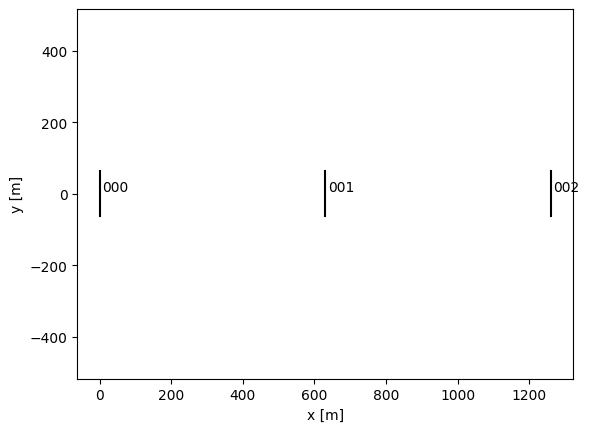

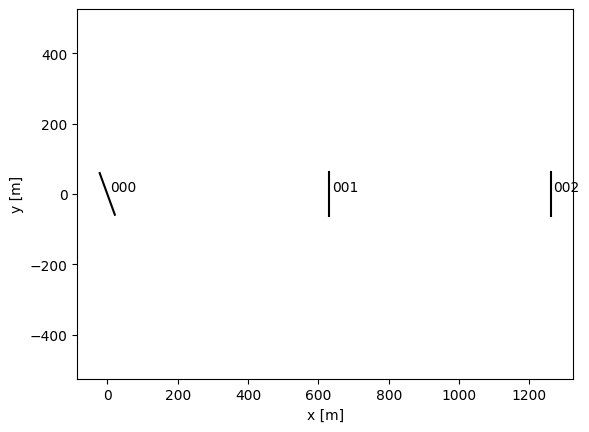

In [1]:
from floris import FlorisModel
from floris import layout_visualization as layoutviz

fmodel = FlorisModel("../examples/inputs/gch.yaml")

# Look at layout
ax = layoutviz.plot_turbine_rotors(fmodel)
layoutviz.plot_turbine_labels(fmodel, ax=ax)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

# Set simple operation model
fmodel.set_operation_model("simple")

# Evalaute the model and extract the power output
fmodel.run()
print("simple operation model powers [kW]: ", fmodel.get_turbine_powers() / 1000)

# Set the yaw angles (which the "simple" operation model does not use
# and change the operation model to "cosine-loss"
fmodel.set(yaw_angles=[[20., 0., 0.]])
fmodel.set_operation_model("cosine-loss")
ax = layoutviz.plot_turbine_rotors(fmodel)
layoutviz.plot_turbine_labels(fmodel, ax=ax)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

# Evaluate again
fmodel.run()
powers_cosine_loss = fmodel.get_turbine_powers()
print("cosine-loss operation model powers [kW]: ", fmodel.get_turbine_powers() / 1000)


## Operation model library

### Simple model
User-level name: `"simple"`

Underlying class: `SimpleTurbine`

Required data on `power_thrust_table`:
- `ref_air_density` (scalar)
- `ref_tilt` (scalar)
- `wind_speed` (list)
- `power` (list)
- `thrust_coefficient` (list)

The `"simple"` operation model describes the "normal" function of a wind turbine, as described by
its power curve and thrust coefficient. It does not respond to any control setpoints, and is most 
often used as a baseline or for users wanting to evaluate wind farms in nominal operation.

### Cosine loss model
User-level name: `"cosine-loss"`

Underlying class: `CosineLossTurbine`

Required data on `power_thrust_table`:
- `ref_air_density` (scalar)
- `ref_tilt` (scalar)
- `wind_speed` (list)
- `power` (list)
- `thrust_coefficient` (list)
- `cosine_loss_exponent_yaw` (scalar)
- `cosine_loss_exponent_tilt` (scalar)

The `"cosine-loss"` operation model describes the decrease in power and thrust produced by a 
wind turbine as it yaws (or tilts) away from the incoming wind. The thrust is reduced by a factor of 
$\cos \gamma$, where $\gamma$ is the yaw misalignment angle, while the power is reduced by a factor 
of $(\cos\gamma)^{p_P}$, where $p_P$ is the cosine loss exponent, specified by `cosine_loss_exponent_yaw`
(or `cosine_loss_exponent_tilt` for tilt angles). The power and thrust produced by the turbine
thus vary as a function of the turbine's yaw angle, set using the `yaw_angles` argument to 
`FlorisModel.set()`.

Text(0, 0.5, 'Power [kW]')

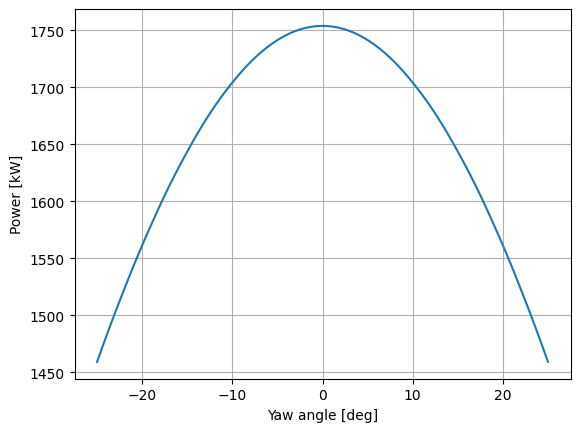

In [2]:
from floris import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

# Set up the FlorisModel
fmodel.set_operation_model("cosine-loss")
fmodel.set(layout_x=[0.0], layout_y=[0.0])
fmodel.set(
    wind_data=TimeSeries(
        wind_speeds=np.ones(100) * 8.0,
        wind_directions=np.ones(100) * 270.0,
        turbulence_intensities=0.06
    )
)
fmodel.reset_operation()

# Sweep the yaw angles
yaw_angles = np.linspace(-25, 25, 100)
fmodel.set(yaw_angles=yaw_angles.reshape(-1,1))
fmodel.run()

powers = fmodel.get_turbine_powers()/1000

fig, ax = plt.subplots()
ax.plot(yaw_angles, powers)
ax.grid()
ax.set_xlabel("Yaw angle [deg]")
ax.set_ylabel("Power [kW]")

### Simple derating model
User-level name: `"simple-derating"`

Underlying class: `SimpleDeratingTurbine`

Required data on `power_thrust_table`:
- `ref_air_density` (scalar)
- `ref_tilt` (scalar)
- `wind_speed` (list)
- `power` (list)
- `thrust_coefficient` (list)

The `"simple-derating"` operation model enables users to derate turbines by setting a new power 
rating. It does not require any extra parameters on the `power_thrust_table`, but adescribes the 
decrease in power and thrust produced by providing the `power_setpoints` argument to
`FlorisModel.set()`. The default power rating for the turbine can be acheived by setting the
appropriate entries of `power_setpoints` to `None`.

/Users/msinner/projects/floris/floris/core/turbine/operation_models.py:358: RuntimeWarning: divide by zero encountered in divide
  power_fractions = power_setpoints / base_powers
/Users/msinner/projects/floris/floris/core/wake_deflection/gauss.py:328: RuntimeWarning: invalid value encountered in divide
  val = 2 * (avg_v - v_core) / (v_top + v_bottom)
/Users/msinner/projects/floris/floris/core/wake_deflection/gauss.py:163: RuntimeWarning: invalid value encountered in divide
  C0 = 1 - u0 / freestream_velocity
/Users/msinner/projects/floris/floris/core/wake_velocity/gauss.py:80: RuntimeWarning: invalid value encountered in divide
  sigma_z0 = rotor_diameter_i * 0.5 * np.sqrt(uR / (u_initial + u0))


Text(0, 0.5, 'Power [kW]')

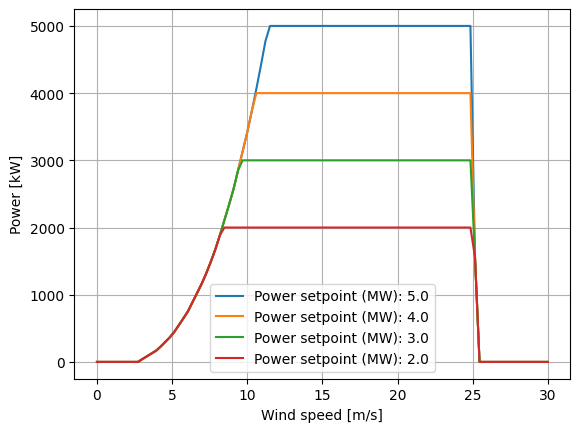

In [3]:
# Set up the FlorisModel
fmodel.set_operation_model("simple-derating")
fmodel.reset_operation()
wind_speeds = np.linspace(0, 30, 100)
fmodel.set(
    wind_data=TimeSeries(
        wind_speeds=wind_speeds,
        wind_directions=np.ones(100) * 270.0,
        turbulence_intensities=0.06
    )
)

fig, ax = plt.subplots()
for power_setpoint in [5.0, 4.0, 3.0, 2.0]:
    fmodel.set(power_setpoints=np.array([[power_setpoint*1e6]]*100))
    fmodel.run()
    powers = fmodel.get_turbine_powers()/1000
    ax.plot(wind_speeds, powers[:,0], label=f"Power setpoint (MW): {power_setpoint}")

ax.grid()
ax.legend()
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power [kW]")

### Mixed operation model
User-level name: `"mixed"`

Underlying class: `MixedOperationTurbine`

Required data on `power_thrust_table`:
- `ref_air_density` (scalar)
- `ref_tilt` (scalar)
- `wind_speed` (list)
- `power` (list)
- `thrust_coefficient` (list)
- `cosine_loss_exponent_yaw` (scalar)
- `cosine_loss_exponent_tilt` (scalar)

The `"mixed"` operation model allows users to specify _either_ `yaw_angles` (evaluated using the 
`"cosine-loss"` operation model) _or_ `power_setpoints` (evaluated using the `"simple-derating"`
operation model). That is, for each turbine, and at each `findex`, a non-zero yaw angle or a 
non-`None` power setpoint may be specified. However, specifying both a non-zero yaw angle and a 
finite power setpoint for the same turbine and at the same `findex` will produce an error.

In [4]:
fmodel.set_operation_model("mixed")
fmodel.set(layout_x=[0.0, 0.0], layout_y=[0.0, 500.0])
fmodel.reset_operation()
fmodel.set(
    wind_data=TimeSeries(
        wind_speeds=np.array([10.0]),
        wind_directions=np.array([270.0]),
        turbulence_intensities=0.06
    )
)
fmodel.set(
    yaw_angles=np.array([[20.0, 0.0]]),
    power_setpoints=np.array([[None, 2e6]])
)
fmodel.run()
print("Powers [kW]: ", fmodel.get_turbine_powers()/1000)

Powers [kW]:  [[3063.49046772 2000.        ]]


### AWC model

User-level name: `"awc"`

Underlying class: `AWCTurbine`

Required data on `power_thrust_table`:
- `ref_air_density` (scalar)
- `ref_tilt` (scalar)
- `wind_speed` (list)
- `power` (list)
- `thrust_coefficient` (list)
- `helix_a` (scalar)
- `helix_power_b` (scalar)
- `helix_power_c` (scalar)
- `helix_thrust_b` (scalar)
- `helix_thrust_c` (scalar)

The `"awc"` operation model allows for users to define _active wake control_ strategies. These strategies 
use pitch control to actively enhance wake mixing and subsequently decrease wake velocity deficits. As a 
result, downstream turbines can increase their power production, with limited power loss for the controlled 
upstream turbine. The `AWCTurbine` class models this power loss at the turbine applying AWC. For each 
turbine, the user can define an AWC strategy to implement through the `awc_modes` array. Note that currently, 
only `"baseline"`, i.e., no AWC, and `"helix"`, i.e., the 
[counterclockwise helix method](https://doi.org/10.1002/we.2513) have been implemented. 

The user then defines the exact AWC implementation through setting the variable `awc_amplitudes` for 
each turbine. This variable defines the mean-to-peak amplitude of the sinusoidal AWC pitch excitation,
i.e., for a turbine that under `awc_modes = "baseline"` has a constant pitch angle of 0 degrees, setting 
`awc_amplitude = 2` results in a pitch signal varying from -2 to 2 degrees over the desired Strouhal
frequency. This Strouhal frequency is not used as an input here, since it has minimal influence on turbine 
power production. Note that setting `awc_amplitudes = 0` effectively disables AWC and is therefore the same 
as running a turbine at `awc_modes = "baseline"`.

Each example turbine input file `floris/turbine_library/*.yaml` has its own `helix_*` parameter data. These 
parameters are determined by fitting data from `OpenFAST` simulations in region II to the following equation:

$$
    P_\text{AWC} = P_\text{baseline} \cdot (1 - (b + c \cdot P_\text{baseline} ) \cdot A_\text{AWC}^a)
$$

where $a$ is `"helix_a"`, $b$ is `"helix_power_b"`, $c$ is `"helix_power_c"`, and $A_\text{AWC}$ is `awc_amplitudes`. 
The thrust coefficient follows the same equation, but with the respective thrust parameters. When AWC is 
turned on while $P_\text{baseline} > P_\text{rated}$, a warning is given as the model is not yet tuned for region III.

The figure below shows the fit between the turbine power and thrust in OpenFAST helix AWC simulations (x) 
and FLORIS simulations (--) at different region II wind speeds for the NREL 5MW reference turbine.

<!--<img src="powerthrust_helix.png" width="600px">-->
![](./powerthrust_helix.png)

In [5]:
fmodel = FlorisModel("../examples/inputs/emgauss_helix.yaml")
fmodel.set_operation_model("awc")
fmodel.set(layout_x=[0.0, 0.0], layout_y=[0.0, 500.0])
fmodel.reset_operation()
fmodel.set(
    wind_speeds=np.array([8.0]),
    wind_directions=np.array([270.0]),
    turbulence_intensities=np.array([0.06])
)
fmodel.set(
    awc_modes=np.array([["helix", "baseline"]]),
    awc_amplitudes=np.array([[2.5, 0]])
)
fmodel.run()
print("Powers [kW]: ", fmodel.get_turbine_powers()/1000)

Powers [kW]:  [[6133.16222884 6301.1399872 ]]


### Peak shaving model

User-level name: `"peak-shaving"`

Underlying class: `PeakShavingTurbine`

Required data on `power_thrust_table`:
- `ref_air_density` (scalar)
- `ref_tilt` (scalar)
- `wind_speed` (list)
- `power` (list)
- `thrust_coefficient` (list)
- `peak_shaving_fraction` (scalar)
- `peak_shaving_TI_threshold` (scalar)

The `"peak-shaving"` operation model allows users to implement peak shaving, where the thrust
of the wind turbine is reduced from the nominal curve near rated to reduce unwanted structural
loading. Peak shaving here is implemented here by reducing the thrust by a fixed fraction from
the peak thrust on the nominal thrust curve, as specified by `peak_shaving_fraction`.This only
affects wind speeds near the peak in the thrust
curve (usually near rated wind speed), as thrust values away from the peak will be below the
fraction regardless. Further, peak shaving is only applied if the turbulence intensity experienced
by the turbine meets the `peak_shaving_TI_threshold`. To apply peak shaving in all wind conditions,
`peak_shaving_TI_threshold` may be set to zero.

When the turbine is peak shaving to reduce thrust, the power output is updated accordingly. Letting
$C_{T}$ represent the thrust coefficient when peak shaving (at given wind speed), and $C_{T}'$
represent the thrust coefficient that the turbine would be operating at under nominal control, then
the power $P$ due to peak shaving (compared to the power $P'$ available under nominal control) is 
computed (based on actuator disk theory) as

$$ P = \frac{C_T (1 - a)}{C_T' (1 - a')} P'$$

where $a$ (respectively, $a'$) is the axial induction factor corresponding to $C_T$
(respectively, $C_T'$), computed using the usual relationship from actuator disk theory,
i.e. the lesser solution to $C_T=4a(1-a)$.


Text(0, 0.5, 'Power [kW]')

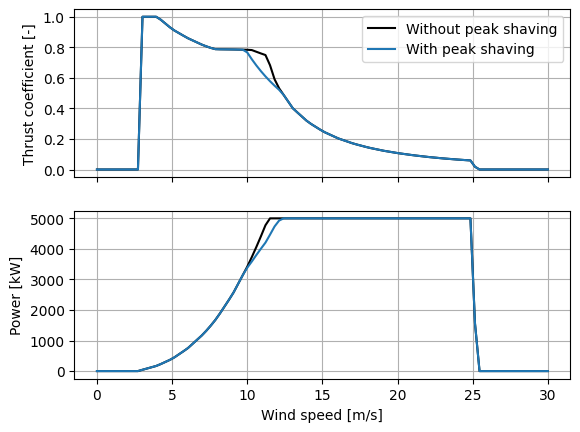

In [6]:
# Set up the FlorisModel
fmodel = FlorisModel("../examples/inputs/gch.yaml")
fmodel.set(
    layout_x=[0.0], layout_y=[0.0],
    wind_data=TimeSeries(
        wind_speeds=wind_speeds,
        wind_directions=np.ones(100) * 270.0,
        turbulence_intensities=0.2 # Higher than threshold value of 0.1
    )
)
fmodel.reset_operation()
fmodel.set_operation_model("simple")
fmodel.run()
powers_base = fmodel.get_turbine_powers()/1000
thrust_coefficients_base = fmodel.get_turbine_thrust_coefficients()
fmodel.set_operation_model("peak-shaving")
fmodel.run()
powers_peak_shaving = fmodel.get_turbine_powers()/1000
thrust_coefficients_peak_shaving = fmodel.get_turbine_thrust_coefficients()

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(wind_speeds, thrust_coefficients_base, label="Without peak shaving", color="black")
ax[0].plot(wind_speeds, thrust_coefficients_peak_shaving, label="With peak shaving", color="C0")
ax[1].plot(wind_speeds, powers_base, label="Without peak shaving", color="black")
ax[1].plot(wind_speeds, powers_peak_shaving, label="With peak shaving", color="C0")

ax[1].grid()
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel("Thrust coefficient [-]")
ax[1].set_xlabel("Wind speed [m/s]")
ax[1].set_ylabel("Power [kW]")

### Controller-dependent model

User-level name: `"controller-dependent"`

Underlying class: `ControllerDependentTurbine`

Required data on `power_thrust_table`:
- `rotor_solidity`: (scalar)
- `rated_rpm`: (scalar)
- `generator_efficiency`: (scalar)
- `rated_power`: (scalar)
- `rotor_diameter`: (scalar)
- `beta`: (scalar)
- `cd`: (scalar)
- `cl_alfa`: (scalar)
- `cp_ct_data_file`: (string)

The `"controller-dependent"` operation model is an advanced operation model that uses the turbine's Cp/Ct
surface to optimize performance under yaw misalignment.

The `"controller-dependent"` operation model determines the wind turbine power output in yaw misalignment conditions, taking into account the effects of the control system. 
When the rotor operates in below-rated conditions, the models assumes that blade pitch is equal to the optimal value (corresponding to maximum power coefficient $C_P$),
while the generator torque is scheduled as a function of rotational speed $\omega$ according to the $K\omega^2$ law.
The $K$ coefficient is computed using the condition of maximum efficiency as shown in Chapter 7 of {cite:t}`hansen_book`.
When the turbine operates above rated wind speed, the rotor speed is fixed and equal to the rated value, while the pitch angle is used to keep the power output equal to rated. 
The `"controller-dependent"` operation model solves a balance equation between electrical power and aerodynamic power, assuming the aforementioned control strategies.
This yields the pitch and torque values that correspond to the current inflow and yaw misalignment. Based on these quantities, the power output of the turbine is computed.
Because the balance equation must be solved, the `ControllerDependentTurbine` is slower to execute than some other operation models.

The `"controller-dependent"` operation model considers the effect of vertical shear. Hence, the wind turbine can perform differently depending on the direction of misalignment.
Vertical shear is computed locally at each rotor, so it can be affected by wake impingement. The model includes both the effects of yaw and tilt on rotor performance.
To include the effects of shear, ensure that `turbine_grid_points` is greater than 1 in the main FLORIS configuration file.

The `"controller-dependent"` operation model requires the definition of some parameters that depend on the turbine:
1) Rated rotation speed (`rated_rpm`), generator efficiency (`generator_efficiency`), and rated power, specified in kW (`rated_power`).
2) Three parameters that describe the aerodynamics of the blade, namely `beta` (twist), `cd` (drag) and `cl_alfa` (lift slope).
These parameters are provided for the NREL 5MW, IEA 10MW, and IEA 15MW turbines in the "floris/turbine_library/".
When using a different turbine model, these parameters can be estimated as shown in Section 3.5 of {cite:t}`tamaro2024beyondcosine`. 
3) Look-up tables of the power coefficient ($C_P$) and thrust coefficient $C_T$ as functions of tip-speed ratio and blade pitch angle.
Approximate values for these are provided for the reference turbines in "floris/turbine_library/".
4) Rotor solidity (`rotor_solidity`), i.e. the fraction of the rotor area occupied by the blades.

Further details can be found in {cite:t}`tamaro2024beyondcosine`.
Developed and implemented by Simone Tamaro, Filippo Campagnolo, and Carlo L. Bottasso at Technische Universität München (TUM) (email: simone.tamaro@tum.de).

floris.logging_manager.LoggingManager WARNING Cp/Ct data provided with FLORIS is for demonstration purposes only, and may not accurately reflect the actual Cp/Ct surfaces of reference wind turbines.


Evaluating model: cosine-loss
Evaluating model: controller-dependent


Text(0, 0.5, 'Normalized turbine power [deg]')

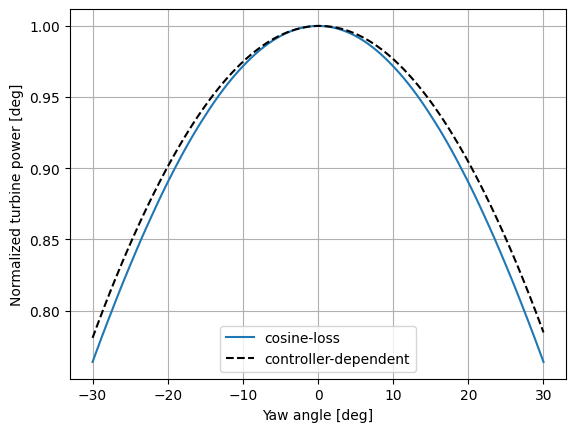

In [7]:
N  = 101 # How many steps to cover yaw range in
yaw_max = 30 # Maximum yaw to test

# Set up the yaw angle sweep
yaw_angles = np.linspace(-yaw_max, yaw_max, N).reshape(-1,1)

# We can use the same FlorisModel, but we'll set it up for this test
fmodel.set(
    wind_data=TimeSeries(
        wind_speeds=np.ones(N) * 8.0,
        wind_directions=np.ones(N) * 270.0,
        turbulence_intensities=0.06
    ),
    yaw_angles=yaw_angles,
)

# We'll compare the "controller-dependent" model to the standard "cosine-loss" model
op_models = ["cosine-loss", "controller-dependent"]
results = {}

for op_model in op_models:
    print(f"Evaluating model: {op_model}")
    fmodel.set_operation_model(op_model)

    fmodel.run()
    results[op_model] = fmodel.get_turbine_powers().squeeze()

fig, ax = plt.subplots()
colors = ["C0", "k"]
linestyles = ["solid", "dashed"]
for key, c, ls in zip(results, colors, linestyles):
    central_power = results[key][yaw_angles.squeeze() == 0]
    ax.plot(yaw_angles.squeeze(), results[key]/central_power, label=key, color=c, linestyle=ls)

ax.grid(True)
ax.legend()
ax.set_xlabel("Yaw angle [deg]")
ax.set_ylabel("Normalized turbine power [deg]")

__WARNING__: The power and thrust curves generated by querying tabulated data as a function of blade pitch and tip-speed ratio for the reference wind turbines is _not_ an exact match for the reference power and thrust curves found at the IEA Wind Task 37's [Github page](https://github.com/IEAWindTask37) or the NREL 5MW [reference data](https://github.com/NREL/turbine-models/blob/master/Offshore/NREL_5MW_126_RWT_corrected.csv). As such, results using the Controller-dependent model, which rely on these $C_P$ and $C_T$ tables, should be considered demonstrative only and not necessarily consistent with other results using the reference wind turbines.

For example, the nominal power and thrust curves for the IEA 15MW, IEA 10MW, and NREL 5MW are shown below, along with their derivations from the provided demonstrative $C_P$ / $C_T$ tables.

floris.logging_manager.LoggingManager WARNING Cp/Ct data provided with FLORIS is for demonstration purposes only, and may not accurately reflect the actual Cp/Ct surfaces of reference wind turbines.
floris.floris_model.FlorisModel WARNING turbine_type has been changed without specifying a new reference_wind_height. reference_wind_height remains 90.00 m. Consider calling `FlorisModel.assign_hub_height_to_ref_height` to update the reference wind height to the turbine hub height.
floris.logging_manager.LoggingManager WARNING Cp/Ct data provided with FLORIS is for demonstration purposes only, and may not accurately reflect the actual Cp/Ct surfaces of reference wind turbines.
/Users/msinner/projects/floris/floris/core/turbine/controller_dependent_operation_model.py:440: RuntimeWarning: invalid value encountered in divide
  u_u_hh = mean_speed / mean_speed[int(np.floor(len(mean_speed) / 2))]
/Users/msinner/projects/floris/floris/core/turbine/controller_dependent_operation_model.py:958: Runt

Powers more than 1% above rated detected. Consider checking Cp-Ct data.


floris.floris_model.FlorisModel WARNING turbine_type has been changed without specifying a new reference_wind_height. reference_wind_height remains 90.00 m. Consider calling `FlorisModel.assign_hub_height_to_ref_height` to update the reference wind height to the turbine hub height.
floris.logging_manager.LoggingManager WARNING Cp/Ct data provided with FLORIS is for demonstration purposes only, and may not accurately reflect the actual Cp/Ct surfaces of reference wind turbines.
floris.floris_model.FlorisModel WARNING turbine_type has been changed without specifying a new reference_wind_height. reference_wind_height remains 90.00 m. Consider calling `FlorisModel.assign_hub_height_to_ref_height` to update the reference wind height to the turbine hub height.
floris.logging_manager.LoggingManager WARNING Cp/Ct data provided with FLORIS is for demonstration purposes only, and may not accurately reflect the actual Cp/Ct surfaces of reference wind turbines.


Powers more than 1% above rated detected. Consider checking Cp-Ct data.


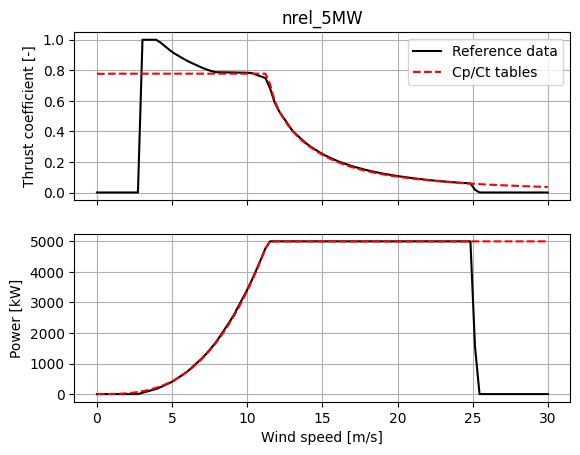

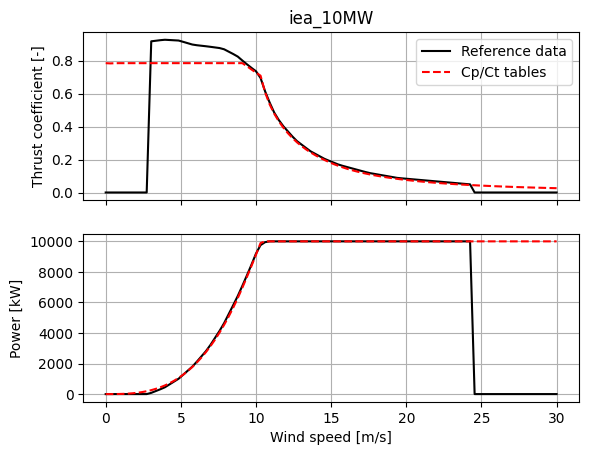

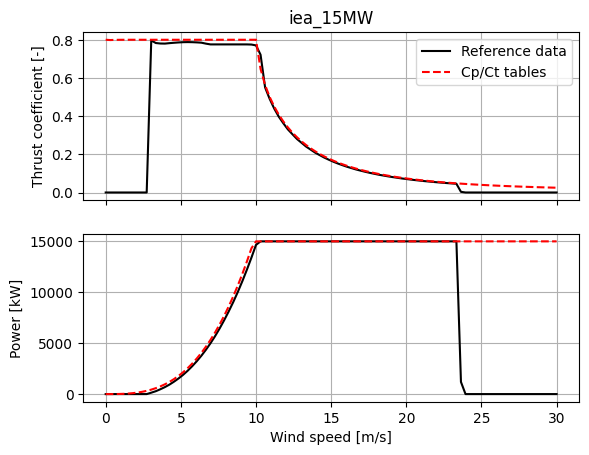

In [8]:
fmodel.reset_operation()
for turbine in ["nrel_5MW", "iea_10MW", "iea_15MW"]:
    fmodel.set(
        layout_x=[0.0], layout_y=[0.0], turbine_type=[turbine],
        wind_data=TimeSeries(
            wind_speeds=wind_speeds,
            wind_directions=np.ones(100) * 270.0,
            turbulence_intensities=0.2 # Higher than threshold value of 0.1
        )
    )
    # Simple model (using reference power and thrust curves)
    fmodel.set_operation_model("simple")
    fmodel.run()
    P_s = fmodel.get_turbine_powers()/1000
    CT_s = fmodel.get_turbine_thrust_coefficients()

    # Controller-dependent model (using demonstration Cp/Ct tables)
    fmodel.set_operation_model("controller-dependent")
    fmodel.run()
    P_cd = fmodel.get_turbine_powers()/1000
    CT_cd = fmodel.get_turbine_thrust_coefficients()

    fig, ax = plt.subplots(2,1,sharex=True)
    ax[0].plot(wind_speeds, CT_s, label="Reference data", color="black")
    ax[0].plot(wind_speeds, CT_cd, label="Cp/Ct tables", color="red", linestyle="--")
    ax[1].plot(wind_speeds, P_s, label="Reference data", color="black")
    ax[1].plot(wind_speeds, P_cd, label="Cp/Ct data", color="red", linestyle="--")

    ax[1].grid()
    ax[0].grid()
    ax[0].legend()
    ax[0].set_ylabel("Thrust coefficient [-]")
    ax[1].set_xlabel("Wind speed [m/s]")
    ax[1].set_ylabel("Power [kW]")
    ax[0].set_title(turbine)

### Unified Momentum Model

User-level name: `"unified-momentum"`

Underlying class: `UnifiedMomentumModelTurbine`

Required data on `power_thrust_table`:
- `ref_air_density` (scalar)
- `ref_tilt` (scalar)
- `wind_speed` (list)
- `power` (list)
- `thrust_coefficient` (list)

An extension of the classical one-dimensional momentum theory to model the induction of an
actuator disk is presented in {cite:t}`HeckJohlasHowland2023_yawed_adm` to directly account
for power and thrust loss due to yaw misalignment rather than using an empirical correction
as in the cosine loss model. Analytical expressions for the induction, thrust, initial wake
velocities and power are developed as a function of the yaw angle and thrust coefficient.

Note that the low thrust limit of the Unified Momentum Model is presently implemented in FLORIS, which returns the equations derived and validated in Heck et al. (2023).
This low thrust limit will be accurate for thrust coefficients approximately less than 0.9.

This section recreates key validation figures discussed in the paper through FLORIS.

Text(0, 0.5, 'Power ratio, $P(\\gamma)/P(0)$')

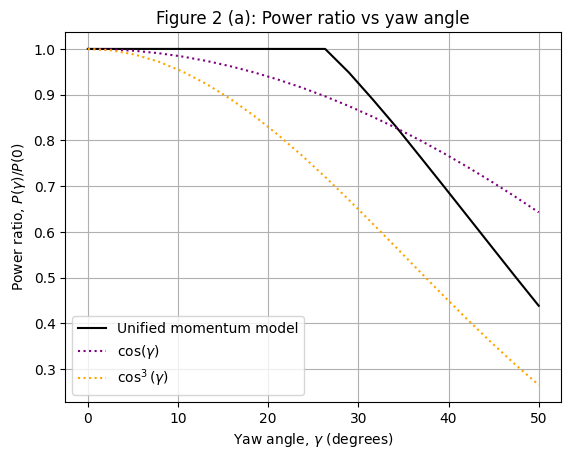

In [11]:
n_points = 20

fmodel.set_operation_model("unified-momentum")
fmodel.set(layout_x=[0.0], layout_y=[0.0])
fmodel.reset_operation()
fmodel.set(
    wind_data=TimeSeries(
        wind_speeds=np.array(n_points * [11.0]),
        wind_directions=np.array(n_points * [270.0]),
        turbulence_intensities=0.06
    )
)
yaw_angles = np.linspace(0, 50, n_points)
cos_reference = np.cos(np.radians(yaw_angles))
cos3_reference = np.cos(np.radians(yaw_angles))**3

fmodel.set(yaw_angles=np.reshape(yaw_angles, (-1,1)))
fmodel.run()

powers = fmodel.get_turbine_powers()
power_ratio_umm = powers[:,0] / powers[0,0]

fig, ax = plt.subplots(1,1)
ax.plot(yaw_angles, power_ratio_umm, label="Unified momentum model", color="black")
ax.plot(yaw_angles, cos_reference, label=r"$\cos(\gamma)$", linestyle=":", color="purple")
ax.plot(yaw_angles, cos3_reference, label=r"$\cos^3(\gamma)$", linestyle=":", color="orange")
ax.grid()
ax.legend()
ax.set_title("Figure 2 (a): Power ratio vs yaw angle")
ax.set_xlabel(r"Yaw angle, $\gamma$ (degrees)")
ax.set_ylabel(r"Power ratio, $P(\gamma)/P(0)$")

Text(0, 0.5, 'Axial induction ratio, $a_n(\\gamma) / a_n(0)$')

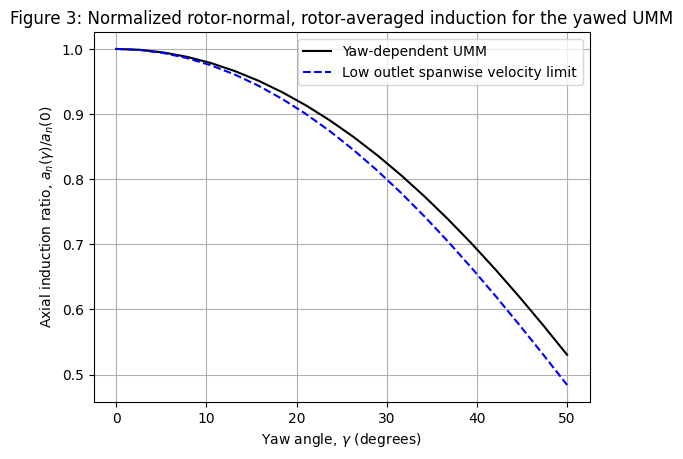

In [ ]:
from floris.core.turbine.unified_momentum_model import Heck, LimitedHeck

n_points = 20
yaw_angles = np.linspace(0, 50, n_points)

ct_prime = 1.33

heck = Heck()
ai_umm = np.array([heck(ct_prime, np.radians(yaw)).an for yaw in yaw_angles])
heck_no_spanwise = LimitedHeck()
ai_no_spanwise = np.array([heck_no_spanwise(ct_prime, np.radians(yaw)).an for yaw in yaw_angles])

fig, ax = plt.subplots(1,1)
ax.plot(yaw_angles, ai_umm / ai_umm[0], label="Yaw-dependent UMM", color="black")
ax.plot(yaw_angles, ai_no_spanwise/ ai_no_spanwise[0], label="Low outlet spanwise velocity limit", linestyle="--", color="blue")
ax.grid()
ax.legend()
ax.set_title("Figure 3: Normalized rotor-normal, rotor-averaged induction for the yawed UMM")
ax.set_xlabel(r"Yaw angle, $\gamma$ (degrees)")
ax.set_ylabel(r"Axial induction ratio, $a_n(\gamma) / a_n(0)$")